# Entraînement baseline du modèle CNN
Ce notebook présente :
- Chargement des données prétraitées
- Définition d’un modèle CNN simple
- Entraînement et évaluation de la baseline
- Sauvegarde du meilleur modèle

## Imports & Paramètres

In [17]:
import os, yaml, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import glob
from src.data_loader import load_from_splits

In [20]:
# Charger la configuration
with open('../configs/config_baseline.yaml') as f:
    cfg = yaml.safe_load(f)

# Fixer les seeds pour la reproductibilité
random.seed(cfg['seed'])
np.random.seed(cfg['seed'])
tf.random.set_seed(cfg['seed'])

# Paramètres depuis la config
# Répertoires
DATA_RAW_DIR       = cfg['data']['raw_dir']
DATA_PROCESSED_DIR = cfg['data']['processed_dir']
CHECKPOINT_DIR = os.path.join('..', 'outputs', 'checkpoints', 'all')
# Hyperparamètres
IMG_SIZE           = tuple(cfg['preprocessing']['target_size'])
BATCH_SIZE         = cfg['training']['batch_size']
EPOCHS             = cfg['training']['epochs']
LEARNING_RATE      = cfg['training']['learning_rate']
EARLYSTOP_CFG      = cfg['training']['early_stopping']

## Chargement des données

In [10]:
# Chemins vers les fichiers de splits
TRAIN_SPLIT = os.path.join('..', 'splits', 'train.txt')
VAL_SPLIT   = os.path.join('..', 'splits', 'val.txt')

# Construction des tf.data.Datasets
train_ds, class_indices = load_from_splits(
    TRAIN_SPLIT,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)
val_ds, _ = load_from_splits(
    VAL_SPLIT,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

# Nombre de classes
num_classes = len(class_indices)
print("Classes et indices :", class_indices)
print("Taille train:", train_ds.cardinality().numpy(),
      "— val:", val_ds.cardinality().numpy())

Found 112 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


## Définition du modèle

In [11]:
def build_baseline_cnn(input_shape, num_classes):
    model = models.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = build_baseline_cnn(IMG_SIZE + (3,), num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,970 (109.26 KB)

 Trainable params: 27,970 (109.26 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks et entraînement

In [ ]:
# Checkpoint
checkpoint_cb = callbacks.ModelCheckpoint(
    os.path.join('../outputs/checkpoints/all',
                 f"baseline_{tf.timestamp().numpy():.0f}.keras"),
    save_best_only=True, monitor="val_accuracy", mode="max"
)

# Early stopping
earlystop_cb = callbacks.EarlyStopping(
    monitor=EARLYSTOP_CFG['monitor'],
    patience=EARLYSTOP_CFG['patience'],
    restore_best_weights=True
)

# Entraînement
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20


/Users/titou/Library/Mobile Documents/com~apple~CloudDocs/Documents/UniNe/Projet de Bachelor/Git/microcoleus-project/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.4302 - loss: 0.6960 - val_accuracy: 0.5185 - val_loss: 0.6949
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5449 - loss: 0.6907 - val_accuracy: 0.4815 - val_loss: 0.6961
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7071 - loss: 0.6849 - val_accuracy: 0.4444 - val_loss: 0.7048
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6922 - loss: 0.6761 - val_accuracy: 0.3333 - val_loss: 0.7133
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7225 - loss: 0.6635 - val_accuracy: 0.4074 - val_loss: 0.7203
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7207 - loss: 0.6544 - val_accuracy: 0.4815 - val_loss: 0.7242


## Visualisation des courbes

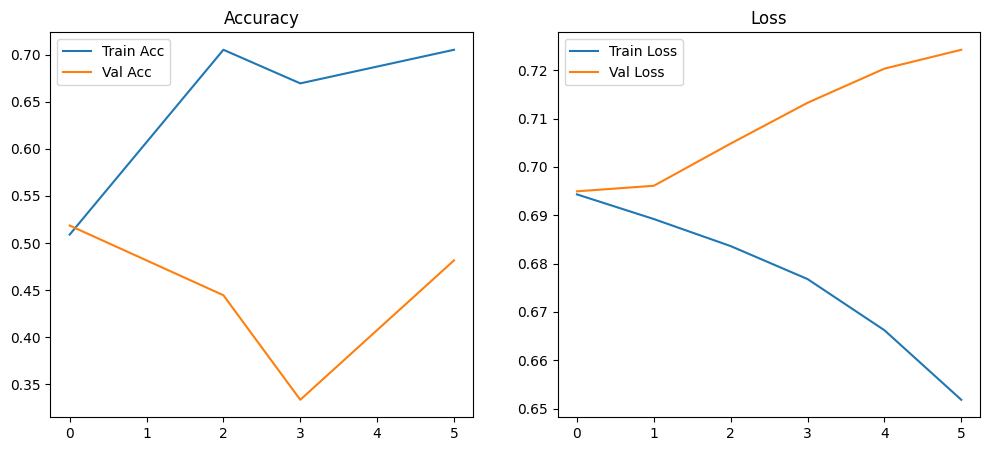

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()

## Sauvegarde finale et exemple de prédiction

In [18]:
# Sauvegarde de la config du run
run_id = f"{int(tf.timestamp().numpy())}"
os.makedirs('../outputs/configs/all', exist_ok=True)
shutil.copy('../configs/config_baseline.yaml', f'../outputs/configs/all/config_baselines_{run_id}.yaml')

'../outputs/configs/all/config_baselines_1745954094.yaml'

In [21]:
# Sauvegarde du model
ckpt_files = glob.glob(os.path.join(CHECKPOINT_DIR, '*.keras'))
latest_ckpt = max(ckpt_files, key=os.path.getctime)
print("Chargement du modèle depuis :", latest_ckpt)

best_model = load_model(latest_ckpt)

# Exemple prédiction
img_path = os.path.join('..', 'data', 'processed', 'all', 'toxic', 'Image_4646.tif')
img = Image.open(img_path).resize(IMG_SIZE)
x = np.array(img) / 255.0

pred = best_model.predict(x[np.newaxis])
pred_label = list(train_gen.class_indices.keys())[np.argmax(pred)]
print(f"Classe prédite : {pred_label} (indices : {train_gen.class_indices})")

Chargement du modèle depuis : ../outputs/checkpoints/all/baseline_1745952211.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Classe prédite : toxic (indices : {'non_toxic': 0, 'toxic': 1})
